In [1]:
# Load dependencies
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as math
import numpy as np
import cv2
import time
import glob as glob
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input,concatenate
# example of progressively loading images from file

In [2]:
PATH = 'input/'

# Get labels

traindf = pd.read_csv(PATH+'train.csv',dtype=str)
traindf["id"]=traindf["id"].apply(lambda x: x[0] + "/" + x[1] + "/" + x[2] + "/" + x +".jpg")

# Dataset Review

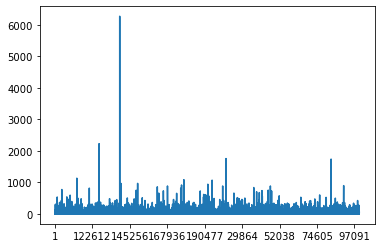

In [3]:
plt.figure()
value_counts = traindf['landmark_id'].value_counts().sort_index()
value_counts.plot()

# Input Training Dataset and Preporocessing

In [4]:
to_remove = value_counts[value_counts > 100].index
traindf = traindf[traindf["landmark_id"].isin(to_remove)]
del to_remove

In [5]:
train_files = glob.glob("input/train/*/*/*/*")

### Sample Images Show

(800, 600, 3)


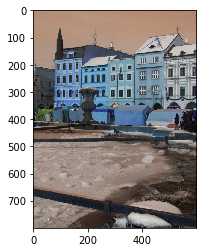

(600, 800, 3)


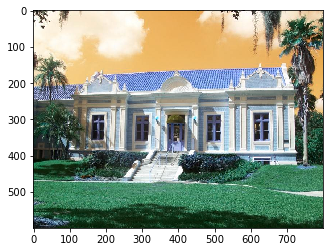

(800, 533, 3)


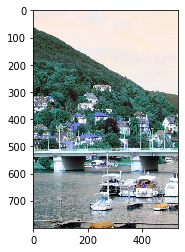

(600, 800, 3)


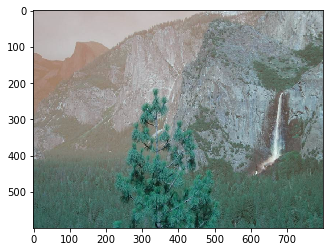

(800, 618, 3)


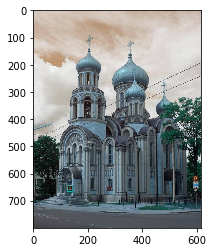

In [6]:
for i in range(0,5):
    print(cv2.imread(train_files[i]).shape)
    plt.imshow(cv2.imread(train_files[i]))
    plt.show()


# Data Generator Class

#### The training dataframe information

In [7]:
print(traindf.info)

<bound method DataFrame.info of                                  id landmark_id
119      0/0/c/00cba0067c078490.jpg          27
120      0/0/f/00f928e383e1d121.jpg          27
121      0/1/1/0110a04e618bc368.jpg          27
122      0/2/6/026afdc670937e3b.jpg          27
123      0/3/1/0319627771784e54.jpg          27
...                             ...         ...
1580370  f/6/2/f62ab3ad531ae6fc.jpg      203071
1580371  f/9/2/f926e9d4e055cb82.jpg      203071
1580372  f/d/1/fd1fde6c257a5945.jpg      203071
1580373  f/d/4/fd4b5377966bd29e.jpg      203071
1580374  f/f/4/ff4cde1706fc4a4c.jpg      203071

[366060 rows x 2 columns]>


In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    # Generate Positive, Negative and Anchor Data
    
    def __init__(self,train,batch_size=1):
        """
        X: filePath, 0/1/9/0193b65bb58d2c77.jpg
        batch_size: int
        img_to_landmark: filepath --> landmark_id; "0/1/9/0193b65bb58d2c77.jpg" --> "9"
        landmakr_to_img: landmark_id --> list of filepaths; "9" --> ["0/1/9/0193b65bb58d2c77.jpg",
                                                                        1/a/3/1a30a51a287ecf69.jpg",
                                                                        ..] 
        """
        self.x = train["id"].unique()
        np.random.shuffle(self.x)
        self.batch_size = BATCH_SIZE
        self.img_to_landmark = train.set_index("id")["landmark_id"].to_dict()
        self.landmark_to_img = train.groupby("landmark_id")["id"].apply(list).to_dict()
        #self.len = tf.math.ceil(len(self.x)/self.batch_size)
        self.len = 20
        self.on_epoch_end()
        pass
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        np.random.shuffle(self.indexes)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        anchor_x = np.array([cv2.resize(cv2.imread("input/train/"+file_name), (128, 128))*1.0/255 for file_name in batch_x])
#         anchor_y = np.array([self.img_to_landmark[file_name] for file_name in batch_x])
#         positive_x,positive_y = self.get_positive(batch_x)
#         negative_x,negative_y = self.get_negative(batch_x)
        
        positive_x = self.get_positive(batch_x)
        negative_x = self.get_negative(batch_x)
        X = [anchor_x,positive_x,negative_x]
        y=np.zeros((len(X),))
        return X,y 
    
    def get_positive(self,batch_x):
        positive_x = []
#         positive_y = []
        for file_name in batch_x:
            landmark = self.img_to_landmark[file_name]
            choice = file_name
            while choice == file_name:
                choice = np.random.choice(self.landmark_to_img[landmark])
            positive_x.append(choice)
#             positive_y.append(self.img_to_landmark[choice])
            
        positive_x = np.array([cv2.resize(cv2.imread("input/train/"+file_name), (128, 128))*1.0/255 for file_name in positive_x])
#       positive_y = np.array(positive_y)
        #positive = np.array(positive)
        
        return positive_x
    
    def get_negative(self,batch_x):
        negative_x = []
#         negative_y = []
        for file_name in batch_x:
            landmark = self.img_to_landmark[file_name]
            choice = file_name
            while self.img_to_landmark[choice] == landmark:
                choice = np.random.choice(self.x)
            negative_x.append(choice)
#             negative_y.append(self.img_to_landmark[choice])
            
        negative_x = np.array([cv2.resize(cv2.imread("input/train/"+file_name), (128, 128))*1.0/255 for file_name in negative_x])
#         negative_y = np.array(negative_y)
        #negative = np.array(negative)
        
        return negative_x
    

# Triple Loss Model </hr>

In [9]:
def base_model(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(128,(7,7),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Conv2D(128,(7,7),padding='same',activation='relu',name='conv3'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool3'))
    model.add(Conv2D(128,(7,7),padding='same',activation='relu',name='conv4'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool4'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    return model



def triplet_loss(y_true,y_pred,alpha=0.5):
    
    total_length = y_pred.shape.as_list()[-1]

    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]
    
    positive_loss = math.sum(math.square(anchor-positive),axis = 1)
    negative_loss = math.sum(math.square(anchor-negative),axis = 1)
    
    return math.maximum(positive_loss-negative_loss+alpha,0.0)
 
    return loss

def build_model():
    anchor_input=Input(shape=(128,128,3))
    positive_input=Input(shape=(128,128,3))
    negative_input=Input(shape=(128,128,3))
    
    base=base_model((128,128,3))
    encoded_anchor = base(anchor_input)
    encoded_positive = base(positive_input)
    encoded_negative = base(negative_input)
    
    merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1)
    model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
    model.compile(loss=triplet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999))
    
    embedding_model = Model(inputs=anchor_input, outputs=encoded_anchor)
    
    return model,embedding_model
model,embedding_model=build_model()
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            2460548     input_4[0][0]                    
                                                                 input_5[0][0]         

In [21]:
BATCH_SIZE,EPOCHS = 32,50
train_generator = DataGenerator(traindf)
history = model.fit(train_generator,  epochs = EPOCHS)

Epoch 1/50
20/20 [==============================] - 202s 10s/step - loss: 0.4158
Epoch 2/50
20/20 [==============================] - 198s 10s/step - loss: 0.4122
Epoch 3/50
20/20 [==============================] - 203s 10s/step - loss: 0.3997
Epoch 4/50
20/20 [==============================] - 205s 10s/step - loss: 0.4088
Epoch 5/50
20/20 [==============================] - 201s 10s/step - loss: 0.4018
Epoch 6/50
20/20 [==============================] - 201s 10s/step - loss: 0.4299
Epoch 7/50
20/20 [==============================] - 201s 10s/step - loss: 0.3826
Epoch 8/50
20/20 [==============================] - 209s 10s/step - loss: 0.3834
Epoch 9/50
20/20 [==============================] - 204s 10s/step - loss: 0.3977
Epoch 10/50
20/20 [==============================] - 200s 10s/step - loss: 0.3832
Epoch 11/50
20/20 [==============================] - 201s 10s/step - loss: 0.4293
Epoch 12/50
20/20 [==============================] - 201s 10s/step - loss: 0.3756
Epoch 13/50
20/20 [======

In [24]:
train_loss = history.history['loss']
plt.plot(train_loss)


[0.4158032238483429, 0.41215410828590393, 0.3996776044368744, 0.4087933897972107, 0.40183526277542114, 0.42990100383758545, 0.38259175419807434, 0.3833518326282501, 0.3977285325527191, 0.38319018483161926, 0.4293191134929657, 0.3755984306335449, 0.4066247045993805, 0.35731545090675354, 0.3755019009113312, 0.38573890924453735, 0.3756350576877594, 0.436105340719223, 0.37898656725883484, 0.3973575234413147, 0.37691575288772583, 0.36635515093803406, 0.38122597336769104, 0.4186691641807556, 0.3830127716064453, 0.35515880584716797, 0.39101487398147583, 0.38011792302131653, 0.3259018659591675, 0.3807457387447357, 0.3452734053134918, 0.36313673853874207, 0.35356107354164124, 0.3467731475830078, 0.3711426556110382, 0.36549898982048035, 0.3674822151660919, 0.3742305636405945, 0.3635699450969696, 0.36971619725227356, 0.34759682416915894, 0.38522422313690186, 0.34061959385871887, 0.349202960729599, 0.3369007706642151, 0.32260051369667053, 0.33062222599983215, 0.35185137391090393, 0.339807122945785

In [25]:
model.save('my_model/1') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model/1\assets
